<a href="https://colab.research.google.com/github/ohikouta/ds_zemi/blob/main/annual_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT本の10章のコードを元に文章ベクトルの作成、文章同士の位置関係を可視化する

In [2]:
# 10-2
!pip install transformers==4.5.0 fugashi==1.1.0 ipadic==1.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 28.1 MB/s 
     |████████████████████████████████| 486 kB 72.8 MB/s 
     |████████████████████████████████| 13.4 MB 66.1 MB/s 
     |████████████████████████████████| 880 kB 58.1 MB/s 
     |████████████████████████████████| 3.3 MB 65.3 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=ecd6403a85062ee4e0c74cd180feae311f814bcdb57a7720cbcd1fd7ea8bd2bf
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=6886060b25b2faa2726ae7c003e815b5728143d08c1fe7854a0ebc3f15c5c0d2
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built ipadic sacremoses


In [3]:
# 10-3
import random
import glob
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertModel

# BERTの日本語モデル
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

In [4]:
# トークナイザとモデルのロード
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
model = model.cuda()

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [20]:
# 各データの形式を揃える
max_length = 256

sentence_vectors = []  # 文章ベクトルを追加

# textを複数使ってfor文で処理させる．
text_list = [
    "私の名前は大井航太です．大学生で勉強を頑張っています．",
    "彼女はうそをついていた．私は絶望した．",
    "サッカー選手になれるのは才能がある人間だけだ．",
    "プログラミングは楽しいが，勉強に時間がかかる．",
    "彼女はやっぱりラーメンを食べに行っていた．",
    "風呂の掃除当番は決まっていない．",
    "給食を早く食べても別にいいことがない．",
    "僕の名前は大井航太。大学生で勉強が好きです。"
]

for text in text_list:
  encoding = tokenizer(
        text, 
        max_length=max_length,
        truncation=True,
        return_tensors='pt'
    )

  encoding = { k: v.cuda() for k, v in encoding.items() }
  attention_mask = encoding['attention_mask']

  # ここは何をしているのかよくわからない
  with torch.no_grad():
        output = model(**encoding)
        last_hidden_state = output.last_hidden_state
        averaged_hidden_state = \
        (last_hidden_state*attention_mask.unsqueeze(-1)).sum(1) \
        / attention_mask.sum(1, keepdim=True)
        
  # 文章ベクトルとラベルを追加
  sentence_vectors.append(averaged_hidden_state[0].cpu().numpy())

# この時点ではsentence_vectorsはリスト
print("="*180)
print(type(sentence_vectors))
print("="*180)

# sentence_vectorsは768×8の形状を持つ
print("=" * 180)
for i in sentence_vectors:
  print(len(i))
print("=" * 180)
# sentence_vectorsの配列を縦方向に結合numpy.ndarrayに型変換
sentence_vectors = np.vstack(sentence_vectors)

# 配列を縦に結合した後の形状を確認
print(type(sentence_vectors))
for i in sentence_vectors:
  print(len(i))
print(len(sentence_vectors))

<class 'list'>
768
768
768
768
768
768
768
768
<class 'numpy.ndarray'>
768
768
768
768
768
768
768
768
8


In [6]:
# このセルは実行しない
# 主成分分析を用いて文章ベクトルを2次元に圧縮
sentence_vectors_pca = PCA(n_components=2).fit_transform(sentence_vectors)
print(sentence_vectors_pca.shape)
print(sentence_vectors)
print(type(sentence_vectors))
print(len(sentence_vectors[0]))

(8, 2)
[[ 0.36568922 -0.11436207 -0.24605513 ... -0.2834818   0.09388372
  -0.28648072]
 [ 0.14830059 -0.37220013 -0.11402325 ... -0.42589533  0.10196778
  -0.12775789]
 [ 0.10375789  0.39231005 -0.28957078 ... -0.30535045  0.582436
  -0.31595674]
 ...
 [-0.033531    0.02532297 -0.09096447 ... -0.25081593 -0.13211855
  -0.16976768]
 [-0.22257906 -0.15858796 -0.13524246 ... -0.44393346  0.20853432
  -0.20745422]
 [ 0.27263427 -0.00780025 -0.2126344  ... -0.19150041  0.01678753
   0.00470024]]
<class 'numpy.ndarray'>
768


In [27]:
# 10-10
# 先にノルムを1にしておく
norm = np.linalg.norm(sentence_vectors, axis=1, keepdims=True)
sentence_vectors_normalized = sentence_vectors / norm

print("="*180)
print(type(sentence_vectors_normalized))
print(sentence_vectors_normalized.shape)
print("="*180)

# 行列の積
# sentence_vectors_normalized(8, 768) * sentence_vectors_normalized.T(768, 8) = sim_matrix(8, 8)
# 結果的にテキストデータの数の要素を行と列に持つ類似度行列ができる

# 類似度行列を計算する
sim_matrix = sentence_vectors_normalized.dot(sentence_vectors_normalized.T)

print("="*180)
print(type(sim_matrix))
print(sim_matrix.shape)
print("="*180)


# 入力と同じ記事の出力をなくす
np.fill_diagonal(sim_matrix, -1)

# 類似度が高い記事のインデックスを得る
similar_news = sim_matrix.argmax(-1)
print("=" * 180)
print(similar_news)
print("=" * 180)
if len(text_list) == len(similar_news):
  print("good")

<class 'numpy.ndarray'>
(8, 768)
<class 'numpy.ndarray'>
(8, 8)
[7 0 0 6 0 6 4 0]
good


In [8]:
len(similar_news)

8

8つの適当なテキストデータを文章ベクトルに変換し、そこから類似度行列を作成した。似ている文章ほど、色が暗くなるようなグラフだが、違いはよくわからない。

特に1つ目の文章と8つ目の文章の内容は人が見ればほとんど同じ内容であるにもかかわらず、類似度が高くならない。

テキストが短すぎる

企業のテキストデータはそれぞれ長いので、はっきり類似度が現れるのではないか。

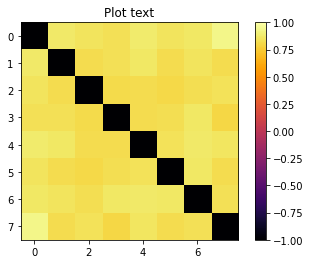

In [9]:
import numpy as np
import matplotlib.pyplot as plt


# fig = plt.figure(figsize=(8,6))
plt.imshow(sim_matrix, cmap="inferno")
plt.title("Plot text")
plt.colorbar()
plt.clim(-1, 1) 
plt.show()